In [93]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import WMAP9 as cosmo
from scipy.integrate import quad
#from astropy.cosmology import Planck15   # You can choose a different cosmology if needed
import astropy.units as u
from astropy import constants as const
from astropy.cosmology import FlatLambdaCDM
from numba import jit

In [94]:

def lx_func(func, fixed_value):
    def f(x):
        return func(fixed_value, x)
    return f

def z_func(func, fixed_value):
    def f(x):
        
        return func(x,fixed_value)
    return f

In [95]:

def simpsons_integration(func, a, b, n=1000):
    h = (b - a) / n
    s = func(a) + func(b)

    for i in range(1, n, 2):
        s += 4 * func(a + i * h)
    for i in range(2, n, 2):
        s += 2 * func(a + i * h)

    return s * h / 3

In [229]:
import pandas as pd
from tabulate import tabulate

def Psi_Ueda(Lx):
     return 1/np.log(10)*1/Lx*((Lx/L_star)**(gamma1)+(Lx/L_star)**(gamma2))**(-1) 



def Psi_Ajello(Lx):
    return 1/Lx*(Lx/L_star)**(1-gamma2) #Function from Ajello et al 


def z_star(Lx): #Calc Z_star used for caculation of XLF for RG
    if (Lx <= L_c):
        return z_c *(Lx/L_c)**alpha
    else:
        return z_c
def z_star_2(Lx): #Calc Z_star used for caculation of XLF for RG
    if (Lx <= L_c_2):
        return z_c_2 *(Lx/L_c_2)**alpha_2
    else:
        return z_c_2

def e_z(z,Lx): #Used in calculation of XLF for RG. redshift evolution is of type PDF
    z_s =z_star(Lx)
    if z<=z_s:
        return (1+z)**(v_1)
    else: 
        return e_z(z_s,Lx) *((1+z)/(1+z_s))**(v_2)

def e_z_PL(z): #Used in calculation of XLF for Blazars, BLlac, and FSRQ. redshift evolution is of type PLF
    
    return (1+z)**(v_1 + v_2*z)

def v_s_1_func(lx):
    
    return v_1 + beta*(np.log10(lx*1.0)-44)

def e_z_all(z,Lx): #Used in calculation of XLF for AGN. redshift evolution is of type PDF
    z_s =z_star(Lx)
    z_s_2 = z_star_2(Lx)
    v_s_1 = v_s_1_func(Lx)
    if z<=z_s:
        return (1+z)**(v_s_1)
    elif z_s<z<=z_s_2: 
        return (1+z_s)**(v_s_1) *((1+z)/(1+z_s))**(v_2)
    else:
        return (1+z_s)**(v_s_1) *((1+z_s_2)/(1+z_s))**(v_2)*((1+z)/(1+z_s_2))**(v_3)


H0 = 70.0  # Hubble constant in km/s/Mpc
Om0 = 0.3  # Matter density parameter (ΩM)
Ode0 = 0.7  # Dark energy density parameter (ΩΛ)

# Create a FlatLambdaCDM cosmology object
cosmo1 = FlatLambdaCDM(H0=H0, Om0=Om0)  # Replace with your desired H0 value



def integrandRG(z, lx): #different integrands, Blazar and FSRQ use the same integrand
   
    
    return Psi_Ueda(lx)*cosmo1.differential_comoving_volume(z).value*e_z(z,lx)

def integrandBlazar(z, lx):
   
    return Psi_Ueda(lx/e_z_PL(z))*cosmo1.differential_comoving_volume(z).value

def integrandBLlac(z, lx):
 
   
    return Psi_Ajello(lx/e_z_PL(z))*cosmo1.differential_comoving_volume(z).value

def integrandAGN(z, lx):
    return Psi_Ueda(lx)*cosmo1.differential_comoving_volume(z).value*e_z_all(z,lx)


model_constants = { #Constants for all models, no unit attached yet
    'SLDDE_RG': {
        'A': 10**(-6.077),
        'L_star': 10**(44.33),
        'gamma1':2.15,
        'gamma2':1.10,
        'v1':4,
        'v2':-1.5,
        'z_c': 1.9,
        'Lc':10**(44.6),
        'alpha':   0.317,
        'z_c_2': 0,
        'alpha_2':0,
        'Lc_2':0,
        'v_3':0,
        'beta': 0,
        'corr_fac': 1,
        'L_lower':42,
         'L_higher':47,
        'integrand':integrandRG,
        
    },
    'AMPLE_Blazar': {
        'A': 1.379*10**(-7),
        'L_star': 1.81*10**(44),
        'gamma1':-0.87,
        'gamma2':2.73,
        'v1':3.45,
        'v2':-0.25,
        'z_c': 0,
        'Lc':0,
        'alpha':   0,
        'z_c_2': 0,
        'alpha_2':0,
        'Lc_2':0,
        'v_3':0,
        'beta': 0,
        'corr_fac': 1,
        'L_lower':44,
         'L_higher':48.5,
        'integrand':integrandBlazar,
        # Add more constants for model 1
    },
     'AMPLE_FSRQ': {
        'A': 0.175*10**(-7),
        'L_star': 2.42*10**(44),
        'gamma1':-50,
        'gamma2':2.49,
        'v1':3.67,
        'v2':-0.30,
        'z_c': 0,
        'z_c_2': 0,
        'alpha_2':0,
        'Lc_2':0,
        'v_3':0,
        'beta': 0,
        'Lc':0,
        'alpha':   0,
        'corr_fac': 1,
        'L_lower':46,
         'L_higher':48.5,
        'integrand':integrandBlazar,
        # Add more constants for model 1
    },
     'APLE_BLlac': {
        'A': 0.830*10**(-7),
        'L_star': 1*10**(44),
        'gamma1':0,
        'gamma2':2.61,
        'v1':-0.79,
        'v2':0,
        'z_c': 0,
        'Lc':0,
        'alpha':   0,
        'z_c_2': 0,
        'alpha_2':0,
        'Lc_2':0,
        'v_3':0,
        'beta': 0,
        'corr_fac': 1,
         'L_lower':44.5,
         'L_higher':48.5,
         'integrand':integrandBLlac,
        # Add more constants for model 1
    },}

model_constants['LDDE_AGN'] = {
        'A': 2.91e-7,
        'L_star': 10**(43.97),
        'gamma1': 0.96,
        'gamma2': 2.71,
        'v1': 4.78,
        'v2': -1.5,
        'z_c': 1.86,    
        'Lc': 10**(44.61),
        'alpha': 0.29,

        'z_c_2': 3,
        'alpha_2':-0.1,
        'Lc_2':10**44,
        'v_3':-6.2,
        'beta': 0.84,

        'corr_fac': 1,
        'L_lower': 42,
        'L_higher': 46,
        'integrand': integrandAGN,
    }



    # Extract the model names and luminosity range from the model_constants dictionary
table_data = []
for model_name, constants in model_constants.items():
    luminosity_range = f"{constants['L_lower']} - {constants['L_higher']}"
    table_data.append([model_name, luminosity_range])

# Generate the LaTeX table
table = tabulate(table_data, headers=['Model Name', 'Luminosity Range'], tablefmt='latex')

# Print the LaTeX table
print(table)




def set_model_constants(model):
    global selected_model, A, L_star, gamma1, gamma2, v_1, v_2, z_c, L_c, alpha, corr_fac, N_steps, L_x, integrand, z_lower, z_upper, a, x, L_x_lower, L_x_upper, Z_list,E_v_list, E1, E2, alpha_2, z_c_2, L_c_2, v_3, beta
    
    selected_model = model
    
    constants = model_constants[selected_model]
    A = constants['A']
    L_star = constants['L_star']
    gamma1 = constants['gamma1']
    gamma2 = constants['gamma2']
    v_1 = constants['v1']
    v_2 = constants['v2']
    z_c = constants['z_c']
    L_c = constants['Lc']
    alpha = constants['alpha']
    corr_fac = constants['corr_fac']

    alpha_2 = constants['alpha_2']
    z_c_2 = constants['z_c_2']
    L_c_2 = constants['Lc_2']
    v_3 = constants['v_3']
    beta = constants['beta']


    N_steps = 40
    L_x = np.logspace(constants["L_lower"], constants["L_higher"], N_steps)

    integrand = constants["integrand"]
    z_lower = 0.01
    z_upper = 2.5

    a = np.log10(L_x[-1]) - np.log10(L_x[0])
    x = L_x / (10.0 ** (44))

    L_x_lower = np.log10(L_x[0])
    L_x_upper = np.log10(L_x[0]) + a / 3
    Z_list = np.linspace(z_lower, 9, N_steps)
    E_v_list = np.linspace(1000,10000000,10) #GeV
    E1 = E_v_list[0]
    E2 = E_v_list[-1]
    
    return 

    # Access constants for the selected model and giving all constants their unit






\begin{tabular}{ll}
\hline
 Model Name   & Luminosity Range   \\
\hline
 SLDDE\_RG     & 42 - 47            \\
 AMPLE\_Blazar & 44 - 48.5          \\
 AMPLE\_FSRQ   & 46 - 48.5          \\
 APLE\_BLlac   & 44.5 - 48.5        \\
 LDDE\_AGN     & 42 - 46            \\
\hline
\end{tabular}


In [230]:
import numpy as np

def prefrom_int(func, list,z_lower,z_upper):

    results = []
    for h in list:
        results.append(A*corr_fac*4*np.pi*simpsons_integration(func(integrand,h), z_lower, z_upper))

    return results

def lum_den_calc():
    integral_results_z_1 = prefrom_int(z_func, L_x,z_lower,z_upper)
    integral_results_z_1  = np.array(integral_results_z_1)
    print("done 1")
    integral_results_z_2 =  prefrom_int(z_func, L_x,z_lower+ 2.5,z_upper+2.5)
    integral_results_z_2 = np.array(integral_results_z_2)
    print("done 2")
    integral_results_z_3 = prefrom_int(z_func, L_x,z_lower+5,z_upper+5)
    integral_results_z_3 = np.array(integral_results_z_3)
    print("done 3")
    integral_results_z_4 =  prefrom_int(z_func, L_x,z_lower+7.5,z_upper+7.5)
    integral_results_z_4 = np.array(integral_results_z_4)

    # Save the data in columns
    data = np.column_stack((integral_results_z_1, integral_results_z_2, integral_results_z_3, integral_results_z_4, L_x, Z_list))
    header = " "+str(z_lower)+ "<" + "z" + "<" + str(z_upper) + ", " + str(z_lower+2.5)+ "<" + "z" + "<" + str(z_upper+2.5) + ", " + str(z_lower+5)+ "<" + "z" + "<" + str(z_upper+5) + ", " + str(z_lower+7.5)+ "<" + "z" + "<" + str(z_upper+7.5) + ", " + "L_x" + ", " + "Z_list"
    #header = "integral_results_z_1,integral_results_z_2,integral_results_z_3,integral_results_z_4,L_x,Z_list"
    np.savetxt('lum_den_data/LD_' + selected_model + '.txt', data, delimiter=',', header=header)



    return integral_results_z_1, integral_results_z_2, integral_results_z_3, integral_results_z_4






In [245]:
 

def red_evo_calc():
    global a1, a2, a3, a4, a5, a6

    if (selected_model == "AMPLE_Blazar"):
        a1 = 44
        a2 = 46.5
        a3 = 46.5
        a4 = 47.5
        a5 = 47.5
        a6 = 48.5

        print("AMPLE_Blazar")
    elif(selected_model == "SLDDE_RG"):
        a1 = 42
        a2 = 43.5
        a3 = 43.5
        a4 = 45
        a5 = 45
        a6 = 47

        print("SLDDE_RG")

    elif(selected_model == "AMPLE_FSRQ"):
        a1 = 46
        a2 = 46.75
        a3 = 46.75
        a4 = 47.5
        a5 = 47.5
        a6 = 48.5
        
        print("AMPLE_FSRQ")

    elif(selected_model == "LDDE_AGN"):
        a1 = 42
        a2 = 43
        a3 = 43
        a4 = 44
        a5 = 45
        a6 = 47
        
        print("LDDE_AGN")
    else:
        a1 = 44.5
        a2 = 45.5
        a3 = 45.5
        a4 = 46.5
        a5 = 47.5
        a6 = 48.5
        print("APLE_BLlac")


    integral_results_lx1 = prefrom_int(lx_func, Z_list,10**a1,10**a2)
    integral_results_lx1 = np.array(integral_results_lx1)
    print("done 1")
    integral_results_lx2 =   prefrom_int(lx_func, Z_list,10**a3,10**a4)
    integral_results_lx2 = np.array(integral_results_lx2)
    print("done 2")
    integral_results_lx3 =  prefrom_int(lx_func, Z_list,10**a5,10**a6)
    integral_results_lx3 = np.array(integral_results_lx3)
    print("done 3")
    integral_results_lx4 =  prefrom_int(lx_func, Z_list,10**a1,10**a6)
    integral_results_lx4 = np.array(integral_results_lx4)


    # Save the data in columns
    data = np.column_stack((integral_results_lx1, integral_results_lx2, integral_results_lx3, integral_results_lx4, L_x, Z_list))
    header = str(a1) + "<" + "log(Lx)" + "<" + str(a2) + ", " + str(a3)+ "<" + "log(Lx)" + "<" + str(a4) + ", " + str(a5)+ "<" + "log(Lx)" + "<" + str(a6) + ", " + str(a1)+ "<" + "log(Lx)" + "<" + str(a6) + ", " + "L_x" + ", " + "Z_list"
    #header = "integral_results_z_1,integral_results_z_2,integral_results_z_3,integral_results_z_4,L_x,Z_list"
    np.savetxt('red_den_data/RD_' + selected_model + '.txt', data, delimiter=',', header=header)

    return integral_results_lx1, integral_results_lx2, integral_results_lx3, integral_results_lx4



In [232]:
##Emissivity j(z) of  my population j(z) = |<L(z)>| * n(z). Can start by setting |<L(z)>| = the average of my bin
def em_j_numerator(z,lx):
    return A*lx*integrand(z,lx)

def em_j_denominator(z,lx):
    return A*integrand(z,lx)

def em_j(z, lowerlim, upperlim):
    a = simpsons_integration(lx_func(em_j_numerator,z), lowerlim, upperlim,n=2000)
    b = simpsons_integration(lx_func(em_j_denominator,z), lowerlim, upperlim,n=2000)
    avg_lx = a/b


    return avg_lx 
def em_avg_calc(arr1,arr2,arr3,arr4):



    n_1 = (arr1)/cosmo1.differential_comoving_volume(Z_list).value
    n_2 = (arr2)/cosmo1.differential_comoving_volume(Z_list).value
    n_3 = (arr3)/cosmo1.differential_comoving_volume(Z_list).value

    n_tot =(arr4)/cosmo1.differential_comoving_volume(Z_list).value



    #print(L_x)

    em_j1 = []
    em_j2 = []
    em_j3 = []
    em_tot = []
    avg_lx1 = []
    avg_lx2 = []
    avg_lx3 = []
    avg_tot = []
    for z in Z_list:
        res1 = em_j(z,10**a1,10**a2)
        res2 = em_j(z,10**a3,10**a4)
        res3 = em_j(z,10**a5,10**a6)
        res = em_j(z,10**a1,10**a6)

        em_j1.append(res1 * n_1[z == Z_list])
        em_j2.append(res2 * n_2[z == Z_list])
        em_j3.append(res3 * n_3[z == Z_list])
        em_tot.append(res * (n_tot[z == Z_list]))
        avg_lx1.append(res1)
        avg_lx2.append(res2)
        avg_lx3.append(res3)
        avg_tot.append(res)
    
    em_j1 = np.array(em_j1)
    em_j1 = np.reshape(em_j1, -1)

    em_j2 = np.array(em_j2)
    em_j2 = np.reshape(em_j2, -1)

    em_j3 = np.array(em_j3)
    em_j3 = np.reshape(em_j3, -1)

    em_tot = np.array(em_tot)
    em_tot = np.reshape(em_tot, -1)

    avg_lx1 = np.array(avg_lx1)
    avg_lx2 = np.array(avg_lx2)
    avg_lx3 = np.array(avg_lx3)
    avg_tot = np.array(avg_tot)
    return em_j1, em_j2, em_j3, em_tot, avg_lx1, avg_lx2, avg_lx3, avg_tot








In [233]:
from scipy.optimize import curve_fit



def power_law(z,a, n):
    
    return a * (1 + z) ** n

# Fit the first array
#popt1, pcov1 = curve_fit(power_law, Z_list, avg_lx1, p0=[avg_lx1[0], 1])
#print(f"Fit parameters for array 1: a={popt1[0]:.2f}, n={popt1[1]:.2f}")

# Fit the second array
#popt2, pcov2 = curve_fit(power_law, Z_list, avg_lx2, p0=[avg_lx2[0], 1])
#print(f"Fit parameters for array 2: a={popt2[0]:.2f}, n={popt2[1]:.2f}")

# Fit the third array
#popt3, pcov3 = curve_fit(power_law, Z_list, avg_lx3, p0=[avg_lx3[0], 1])
#print(f"Fit parameters for array 3: a={popt3[0]:.2f}, n={popt3[1]:.2f}")
# Define the broken power law function
def broken_power_law(z, a, b, c, e):
    

    return a*((z/c)**b+(z/c)**e)**(-1)

def return_fit_varaibles(avg_lx1, avg_lx2, avg_lx3, avg_tot, em_tot, n_tot,c):

    print("The model in question is: ", selected_model)
    # Fit the first array
    popt1, pcov1 = curve_fit(broken_power_law, Z_list, avg_lx1, p0=[avg_lx1[0], 1, c, -1])
    print(f"Fit parameters for array 1: a={popt1[0]:.2f}, b={popt1[1]:.2f}, c={popt1[2]:.2f}, e={popt1[3]:.2f}")

    # Fit the second array
    popt2, pcov2 = curve_fit(broken_power_law, Z_list, avg_lx2, p0=[avg_lx2[0], 1, c, -1])
    print(f"Fit parameters for array 2: a={popt2[0]:.2f}, b={popt2[1]:.2f}, c={popt2[2]:.2f}, e={popt2[3]:.2f}")

    # Fit the third array
    popt3, pcov3 = curve_fit(broken_power_law, Z_list, avg_lx3, p0=[avg_lx3[0], 1, c, -1])
    print(f"Fit parameters for array 3: a={popt3[0]:.2f}, b={popt3[1]:.2f}, c={popt3[2]:.2f}, e={popt3[3]:.2f}")



    # Fit the first array
    popt_tot, pcov_tot= curve_fit(broken_power_law, Z_list, avg_tot, p0=[avg_tot[0], 1, c, -1])
    print(f"Fit parameters for avg_tot: a={popt_tot[0]:.2f}, b={popt_tot[1]:.2f}, c={popt_tot[2]:.2f}, e={popt_tot[3]:.2f}")



    popt_tot_em, pcov_tot_em= curve_fit(broken_power_law, Z_list, em_tot, p0=[em_tot[0], 1, c, -1])
    print(f"Fit parameters for em_tot: a={popt_tot_em[0]:.2f}, b={popt_tot_em[1]:.2f}, c={popt_tot_em[2]:.2f}, e={popt_tot_em[3]:.2f}")


    popt_tot_n, pcov_tot_n= curve_fit(broken_power_law, Z_list, n_tot, p0=[n_tot[0], 1, c, -1])
    print(f"Fit parameters for n_tot: a={popt_tot_n[0]:.2f}, b={popt_tot_n[1]:.2f}, c={popt_tot_n[2]:.2f}, e={popt_tot_n[3]:.2f}")

    return popt1, popt2, popt3, popt_tot, popt_tot_em, popt_tot_n







In [234]:
from scipy.optimize import minimize

def SED_neut(E_v,D): #general SED for all neutrino emmision from the tpye of AGN considered
    return D*E_v**(-2.37) #2.2 comes from some paper i think


def integrate_SED(D,func): #Want this to equate the luminosity of our AGN, This luminosity is redshift dependent. 
    integral, _ = quad(func, E1, E2, args=(D))
    #print(integral)
    return integral


def objective_function(D, target_luminosity,func):
   
    return abs(integrate_SED(D,func) - target_luminosity)

#def D_func(z,a,b,c,d):
#    return a*((z/c)**b+(z/c)**d)**(-1)

def D_func(lx,a,b):
    return a*lx+b


#print(integrate_SED(2.829371152471951e+42))

#D_init = 2.829371152471951e+42
#z_trial = 0.01
#print(broken_power_law(z_trial, *popt_tot))
def D_list_calc(c):
    
    D_list = []

    for i in range(len(Z_list)):
        z_trial = Z_list[i]
        D_init = broken_power_law(z_trial, *popt_tot)* 624.15 #conversion from ergs to GeV
        Neutrino_luminosity = broken_power_law(z_trial, *popt_tot)* 624.15
        result = minimize(objective_function, D_init, args=(Neutrino_luminosity,SED_neut),method='Nelder-Mead')
        D_list.append(result.x[0])
    
    D_list = []
    for i in range(len(L_x)):
        lx = L_x[i]
        D_init = lx*624.15
        Neutrino_luminosity = lx*624.15
        result = minimize(objective_function, D_init, args=(Neutrino_luminosity,SED_neut),method='Nelder-Mead')
        D_list.append(result.x[0])


    #result = minimize(objective_function, D_init, args=(broken_power_law(z_trial, *popt_tot)),method='Nelder-Mead')
    D_list = np.array(D_list)

    #popt_tot_D, pcov_tot_D= curve_fit(D_func, Z_list, D_list, p0=[D_list[0], 1, c, 1]) #c param very important and volatile
    #print(f"Fit parameters for D_list: a={popt_tot_D[0]:.2f}, b={popt_tot_D[1]:.2f}, c={popt_tot_D[2]:.8f}, d={popt_tot_D[3]:.2f}")
    popt_tot_D, pcov_tot_D= curve_fit(D_func, L_x, D_list, p0=[D_list[0], 1]) #c param very important and volatile
    print(f"Fit parameters for D_list: a={popt_tot_D[0]:.2f}, b={popt_tot_D[1]:.2f}")

    plt.figure(figsize=(10, 8))
    plt.plot(L_x,D_list)
    plt.plot(L_x,D_func(L_x,*popt_tot_D))
    plt.xscale('log')
    plt.yscale('log')
    plt.show()


    return D_list, popt_tot_D




In [235]:
def flux_integrand(z):
    Dh = cosmo.hubble_distance.value  # Hubble distance in Mpc
    E_z = cosmo.efunc(z)  # E(z) function from astropy
 
    #return (Dh / E_z) * SED_neut(Ev*(1+z),(D_func(z,*popt_tot_D))) / (Ev**2 *4 * np.pi * (1 + z)**2 )* broken_power_law(z, *popt_tot_n)
    return (Dh / E_z) * SED_neut(Ev*(1+z),(D_func(broken_power_law(z, *popt_tot),*popt_tot_D))) / (Ev**2 *4 * np.pi * (1 + z)**2 )* broken_power_law(z, *popt_tot_n)

def calc_phi():
    global Ev
    d_phi = []

    for i in range(len(E_v_list)):
        Ev = E_v_list[i]

        

        results_flux = simpsons_integration(flux_integrand, 0.001, 9,n=2000)
        d_phi.append(results_flux/(3.0857*10**24)**2) #convert from Mpc^2 to cm^2 

    d_phi = np.array(d_phi)
    return d_phi



#print(results_flux/1e18)

# Plot the results_flux as a point
#plt.plot(1, results_flux, 'ro')

# Grey out the area below 10^(-8)
#plt.fill_between([0, 2], 0, 1e-8, color='gray', alpha=0.5)

# Set the y-axis scale to logarithmic
#plt.yscale('log')

# Set the x-axis and y-axis labels
#plt.xlabel('x-axis label')
#plt.ylabel('y-axis label')

# Show the plot
#plt.show()

In [236]:
def ICECUBE(E_v, E_cut,gamma,phi_cut):
    return phi_cut*(E_v/100000)**(-gamma)*np.exp(-(E_v/E_cut))


E_cut_ice = 1250000 #GeV
gamma = 2.37 #dimensionless
phi_cut = 1.64*10**(-18) #C units
#E_v_list = np.linspace(0.01,2000,400)*(10**3) #GeV


In [237]:
from scipy.integrate import dblquad
from scipy.optimize import minimize

def SED_neut_2(E_v,D,Lx): #general SED for all neutrino emmision from the tpye of AGN considered
    E_cut = func(Lx)
    return D*E_v**(-2)#*np.exp(-E_v/E_cut) #2.2 comes from some paper i think

def func(Lx):
    below = 10**43
    return 100000*(Lx/below)**(0.25)

def integrate_SED_2(D,lx,func): #Want this to equate the luminosity of our AGN, This luminosity is redshift dependent. 
    integral, _ = quad(func, E1, E2, args=(D,lx))
    #print(integral)
    return integral


def objective_function_2(D, target_luminosity,func):
   
    return abs(integrate_SED_2(D,target_luminosity,func) - target_luminosity)




def lin_func(lx,a,b):
    return a*lx+b
def D_fit_2():

    D_list_2 = []
    for i in range(len(L_x)):
        lx = L_x[i]
        D_init =lx* 624.15 #conversion from ergs to GeV
        Neutrino_luminosity = lx* 624.15
        result = minimize(objective_function_2, D_init, args=(Neutrino_luminosity,SED_neut_2),method='Nelder-Mead')
        #print(lx, np.log10(result.x[0]))
        D_list_2.append(result.x[0])

    popt_tot_D_2, pcov_tot_D_2= curve_fit(lin_func, L_x, D_list_2, p0=[ D_list_2[0],1]) 
    print(f"Fit parameters for D_list: a={popt_tot_D_2[0]:.2f}, b={popt_tot_D_2[1]:.2f}")

    return D_list_2, popt_tot_D_2







In [238]:



def flux_integrand_2(z,lx):
    Dh = cosmo.hubble_distance.value  # Hubble distance in Mpc
    E_z = cosmo.efunc(z)  # E(z) function from astropy
    D = lin_func(lx, *popt_tot_D_2)
    
    return (Dh / E_z) * SED_neut_2(Ev*(1+z),D,lx*624.15) / (Ev**2 *4 * np.pi * (1 + z)**2 )* integrand(z,lx)/cosmo1.differential_comoving_volume(z).value



def calc_phi_2():
    print(len(E_v_list))
    global Ev

    # Define the integration limits for z and lx
    z_min = z_lower
    z_max = 9
    lx_min = L_x[0]  # Replace with the minimum value for lx
    lx_max = L_x[-1]  # Replace with the maximum value for lx

    # Perform the double integration
    #result, error = dblquad(flux_integrand_2, lx_min, lx_max, lambda lx: z_min, lambda lx: z_max)

    #print(result)


    d_phi_2 = []
    print("Start phi2 calc for " + selected_model)
    for i in range(len(E_v_list)):
        Ev = E_v_list[i]

        
        
        result, error = dblquad(flux_integrand_2, lx_min, lx_max,  z_min,  z_max,epsabs=1e-01, epsrel=1.49e-01)
   
        #print(i)
        d_phi_2.append(result/(3.0857*10**24)**2) #convert from Mpc^2 to cm^2 

    print("End")
    d_phi_2 = np.array(d_phi_2)
    return d_phi_2





done 1
done 2
done 3
AMPLE_Blazar
done 1
done 2
done 3
The model in question is:  AMPLE_Blazar
Fit parameters for array 1: a=11451616352688064310919219318678889411796533248.00, b=-1.23, c=5.59, e=3.15
Fit parameters for array 2: a=98211956629262785119701486594504313707002068992.00, b=-0.00, c=98.55, e=0.00
Fit parameters for array 3: a=981279776782762341251051967695495801811243106304.00, b=-0.00, c=1.70, e=0.00
Fit parameters for avg_tot: a=12336889810168348639218134370323076392188641280.00, b=3.23, c=5.48, e=-1.33
Fit parameters for em_tot: a=650515505629626602580294554285991689977856.00, b=4.48, c=5.07, e=-2.14
Fit parameters for n_tot: a=0.00, b=-1.35, c=5.46, e=3.25


C:\Users\henri\AppData\Local\Temp\ipykernel_5492\3311138847.py:24: RuntimeWarning: invalid value encountered in power
  return a*((z/c)**b+(z/c)**e)**(-1)
C:\Users\henri\AppData\Local\Temp\ipykernel_5492\3311138847.py:24: RuntimeWarning: overflow encountered in power
  return a*((z/c)**b+(z/c)**e)**(-1)
c:\Users\henri\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Fit parameters for D_list: a=11015671.60, b=1.00


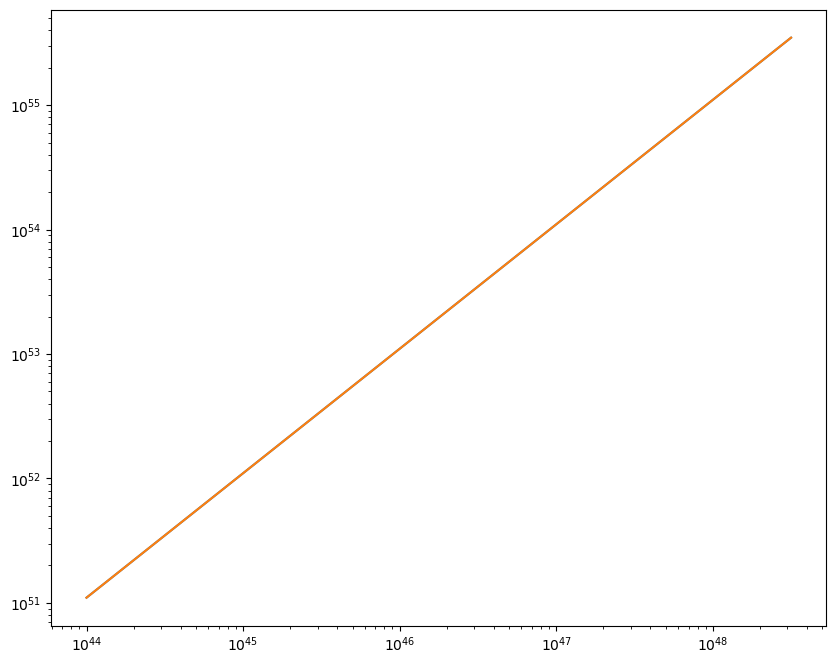

Fit parameters for D_list: a=624212.42, b=1.00
10
Start phi2 calc for AMPLE_Blazar
End


In [250]:
selected_model = 'AMPLE_Blazar'
#different models 'SLDDE_RG', 'AMPLE_Blazar', 'AMPLE_FSRQ', 'APLE_BLlac'
set_model_constants(selected_model)

blaz_ir_z1, blaz_ir_z2, blaz_ir_z3, blaz_ir_z4 = lum_den_calc()
blaz_ir_lx1, blaz_ir_lx2, blaz_ir_lx3, blaz_ir_lx4 = red_evo_calc()
blaz_em_j1, blaz_em_j2, blaz_em_j3, blaz_em_tot, blaz_avg_lx1, blaz_avg_lx2, blaz_avg_lx3, blaz_avg_tot = em_avg_calc(blaz_ir_lx1, blaz_ir_lx2, blaz_ir_lx3, blaz_ir_lx4)

blaz_n_tot =(blaz_ir_lx1)/cosmo1.differential_comoving_volume(Z_list).value
popt1, popt2, popt3, popt_tot, popt_tot_em, popt_tot_n = return_fit_varaibles(blaz_avg_lx1, blaz_avg_lx2, blaz_avg_lx3, blaz_avg_tot, blaz_em_tot, blaz_n_tot,4)
D_list, popt_tot_D = D_list_calc(4)
blaz_d_phi = calc_phi()
D_list_2, popt_tot_D_2 = D_fit_2()
blaz_d_phi_2 = calc_phi_2()


done 1
done 2
done 3
SLDDE_RG
done 1
done 2
done 3
The model in question is:  SLDDE_RG
Fit parameters for array 1: a=7880528129306117106974826088379001006456832.00, b=-0.13, c=29.72, e=0.92
Fit parameters for array 2: a=208460953111043717073390185959093149995368448.00, b=2.10, c=15.47, e=-0.23
Fit parameters for array 3: a=3821663355930172863655890097520379395410231296.00, b=-0.00, c=2.18, e=0.00
Fit parameters for avg_tot: a=6051177094736435124597411771038945178025984.00, b=0.28, c=1.70, e=-1.17
Fit parameters for em_tot: a=218780239458422771718080878485216820199424.00, b=1.97, c=2.86, e=-0.22
Fit parameters for n_tot: a=0.01, b=1.42, c=0.92, e=-0.37


C:\Users\henri\AppData\Local\Temp\ipykernel_5492\3311138847.py:24: RuntimeWarning: invalid value encountered in power
  return a*((z/c)**b+(z/c)**e)**(-1)


Fit parameters for D_list: a=11015671.60, b=1.00


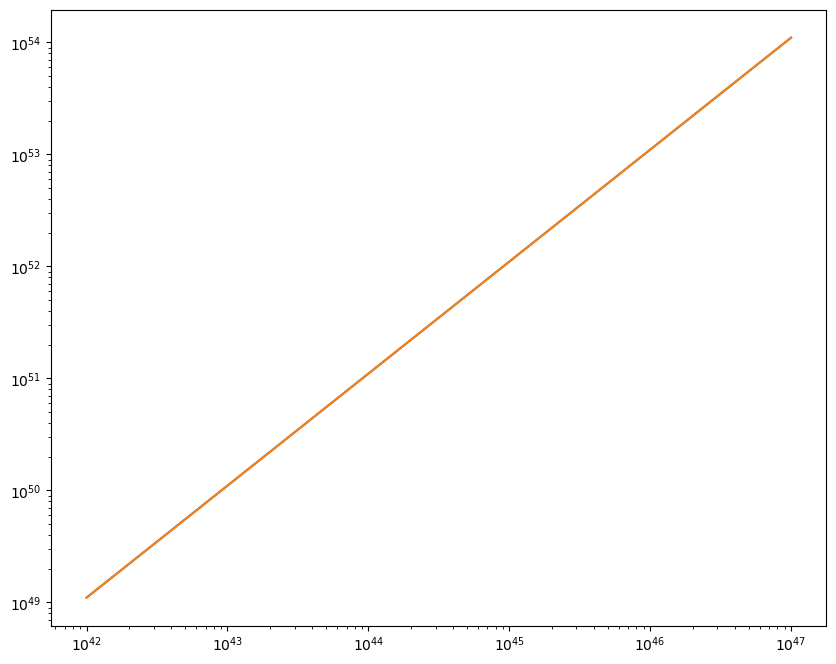

Fit parameters for D_list: a=624212.42, b=1.00
10
Start phi2 calc for SLDDE_RG
End


In [251]:
selected_model = 'SLDDE_RG'
#different models 'SLDDE_RG', 'AMPLE_Blazar', 'AMPLE_FSRQ', 'APLE_BLlac'
set_model_constants(selected_model)
rg_ir_z1, rg_ir_z2, rg_ir_z3, rg_ir_z4 = lum_den_calc()
rg_ir_lx1, rg_ir_lx2, rg_ir_lx3, rg_ir_lx4 = red_evo_calc()
rg_em_j1, rg_em_j2, rg_em_j3, rg_em_tot, rg_avg_lx1, rg_avg_lx2, rg_avg_lx3, rg_avg_tot = em_avg_calc(rg_ir_lx1, rg_ir_lx2, rg_ir_lx3, rg_ir_lx4)

rg_n_tot =(rg_ir_lx1)/cosmo1.differential_comoving_volume(Z_list).value
popt1, popt2, popt3, popt_tot, popt_tot_em, popt_tot_n = return_fit_varaibles(rg_avg_lx1, rg_avg_lx2, rg_avg_lx3, rg_avg_tot, rg_em_tot, rg_n_tot,1.5)
D_list, popt_tot_D = D_list_calc(0.5)
rg_d_phi = calc_phi()
D_list_2, popt_tot_D_2 = D_fit_2()
rg_d_phi_2 = calc_phi_2()


done 1
done 2
done 3
AMPLE_FSRQ
done 1
done 2
done 3
The model in question is:  AMPLE_FSRQ
Fit parameters for array 1: a=18248867615398720794258530077930878000108142592.00, b=3.52, c=13.94, e=-0.04
Fit parameters for array 2: a=175998381597538998251644326690603567301714247680.00, b=-0.00, c=12.29, e=0.00
Fit parameters for array 3: a=1026041199116370415335104100037732484265891856384.00, b=-0.00, c=8.73, e=0.00
Fit parameters for avg_tot: a=19955804112576489900506188946186163862141665280.00, b=3.53, c=13.23, e=-0.04
Fit parameters for em_tot: a=34778181066295542464491088771724404064256.00, b=-0.15, c=287.21, e=14.37
Fit parameters for n_tot: a=0.00, b=-0.15, c=219.34, e=9.39


C:\Users\henri\AppData\Local\Temp\ipykernel_5492\3311138847.py:24: RuntimeWarning: invalid value encountered in power
  return a*((z/c)**b+(z/c)**e)**(-1)


Fit parameters for D_list: a=11015671.60, b=1.00


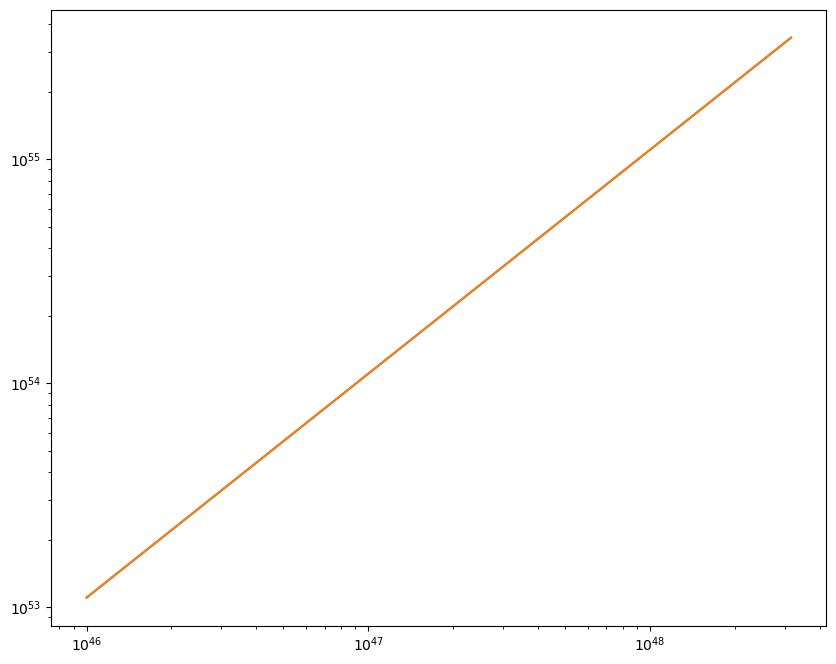

Fit parameters for D_list: a=624212.42, b=1.00
10
Start phi2 calc for AMPLE_FSRQ


c:\Users\henri\anaconda3\lib\site-packages\scipy\integrate\_quadpack_py.py:1151: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


End


In [252]:
selected_model = 'AMPLE_FSRQ'
#different models 'SLDDE_RG', 'AMPLE_Blazar', 'AMPLE_FSRQ', 'APLE_BLlac'
set_model_constants(selected_model)
fsrq_ir_z1, fsrq_ir_z2, fsrq_ir_z3, fsrq_ir_z4 = lum_den_calc()
fsrq_ir_lx1, fsrq_ir_lx2, fsrq_ir_lx3, fsrq_ir_lx4 = red_evo_calc()
fsrq_em_j1, fsrq_em_j2, fsrq_em_j3, fsrq_em_tot, fsrq_avg_lx1, fsrq_avg_lx2, fsrq_avg_lx3, fsrq_avg_tot = em_avg_calc(fsrq_ir_lx1, fsrq_ir_lx2, fsrq_ir_lx3, fsrq_ir_lx4)

fsrq_n_tot =(fsrq_ir_lx1)/cosmo1.differential_comoving_volume(Z_list).value
popt1, popt2, popt3, popt_tot, popt_tot_em, popt_tot_n = return_fit_varaibles(fsrq_avg_lx1, fsrq_avg_lx2, fsrq_avg_lx3, fsrq_avg_tot, fsrq_em_tot, fsrq_n_tot,4)
D_list, popt_tot_D = D_list_calc(4)
fsrq_d_phi = calc_phi()
D_list_2, popt_tot_D_2 = D_fit_2()
fsrq_d_phi_2 = calc_phi_2()

done 1
done 2
done 3
APLE_BLlac
done 1
done 2
done 3
The model in question is:  APLE_BLlac
Fit parameters for array 1: a=1291206569108579071999808470834681992886353920.00, b=-0.00, c=0.95, e=0.00
Fit parameters for array 2: a=12912065691011549178032468168161413634761687040.00, b=-0.00, c=0.81, e=0.00
Fit parameters for array 3: a=1291206568484071874673333612980929986992969613312.00, b=-0.00, c=1.28, e=0.00
Fit parameters for avg_tot: a=887395178833082670527875457908016499965034496.00, b=-0.00, c=1.09, e=0.00
Fit parameters for em_tot: a=176782697162783666985378243326941069312.00, b=1.60, c=0.65, e=0.07
Fit parameters for n_tot: a=0.00, b=1.60, c=0.65, e=0.07


C:\Users\henri\AppData\Local\Temp\ipykernel_5492\3311138847.py:24: RuntimeWarning: invalid value encountered in power
  return a*((z/c)**b+(z/c)**e)**(-1)


Fit parameters for D_list: a=11015671.60, b=1.00


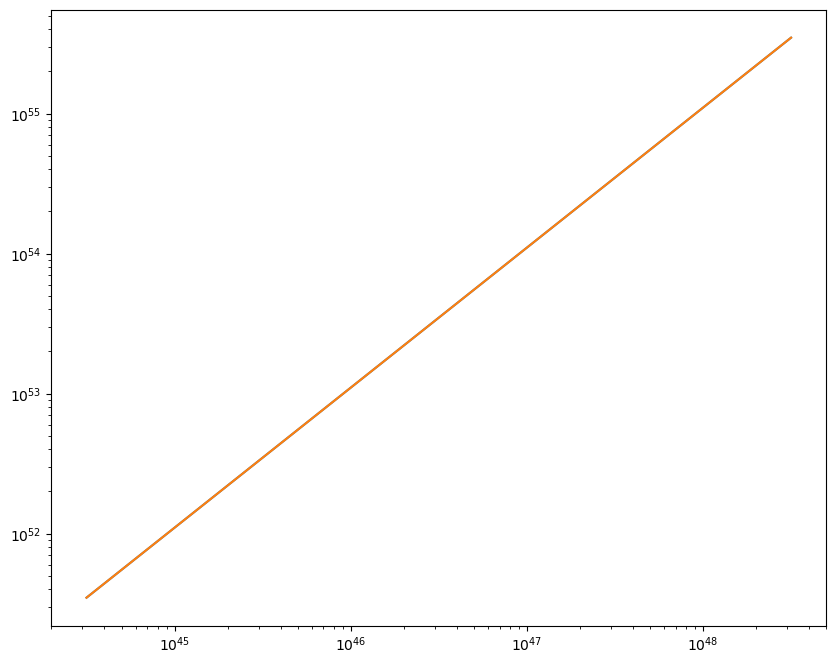

Fit parameters for D_list: a=624212.42, b=1.00
10
Start phi2 calc for APLE_BLlac
End


In [253]:
selected_model = 'APLE_BLlac'
#different models 'SLDDE_RG', 'AMPLE_Blazar', 'AMPLE_FSRQ', 'APLE_BLlac'
set_model_constants(selected_model)
bllac_ir_z1, bllac_ir_z2, bllac_ir_z3, bllac_ir_z4 = lum_den_calc()
bllac_ir_lx1, bllac_ir_lx2, bllac_ir_lx3, bllac_ir_lx4 = red_evo_calc()
bllac_em_j1, bllac_em_j2, bllac_em_j3, bllac_em_tot, bllac_avg_lx1, bllac_avg_lx2, bllac_avg_lx3, bllac_avg_tot = em_avg_calc(bllac_ir_lx1, bllac_ir_lx2, bllac_ir_lx3, bllac_ir_lx4)

bllac_n_tot =(bllac_ir_lx1)/cosmo1.differential_comoving_volume(Z_list).value
popt1, popt2, popt3, popt_tot, popt_tot_em, popt_tot_n = return_fit_varaibles(bllac_avg_lx1, bllac_avg_lx2, bllac_avg_lx3, bllac_avg_tot, bllac_em_tot, bllac_n_tot,0.5)
D_list, popt_tot_D = D_list_calc(3)
bllac_d_phi = calc_phi()
D_list_2, popt_tot_D_2 = D_fit_2()
bllac_d_phi_2 = calc_phi_2()

In [265]:
selected_model = 'LDDE_AGN'
#different models 'SLDDE_RG', 'AMPLE_Blazar', 'AMPLE_FSRQ', 'APLE_BLlac, LDDE_AGN'
set_model_constants(selected_model)
AGN_ir_z1, AGN_ir_z2, AGN_ir_z3, AGN_ir_z4 = lum_den_calc()
AGN_ir_lx1, AGN_ir_lx2, AGN_ir_lx3, AGN_ir_lx4 = red_evo_calc()
AGN_em_j1, AGN_em_j2, AGN_em_j3, AGN_em_tot, AGN_avg_lx1, AGN_avg_lx2, AGN_avg_lx3, AGN_avg_tot = em_avg_calc(AGN_ir_lx1, AGN_ir_lx2, AGN_ir_lx3, AGN_ir_lx4)

AGN_n_tot =(AGN_ir_lx1)/cosmo1.differential_comoving_volume(Z_list).value
#popt1, popt2, popt3, popt_tot, popt_tot_em, popt_tot_n = return_fit_varaibles(AGN_avg_lx1, AGN_avg_lx2, AGN_avg_lx3, AGN_avg_tot, AGN_em_tot, AGN_n_tot,4)
#D_list, popt_tot_D = D_list_calc(3)
#AGN_d_phi = calc_phi()
#D_list_2, popt_tot_D_2 = D_fit_2()
#AGN_d_phi_2 = calc_phi_2()


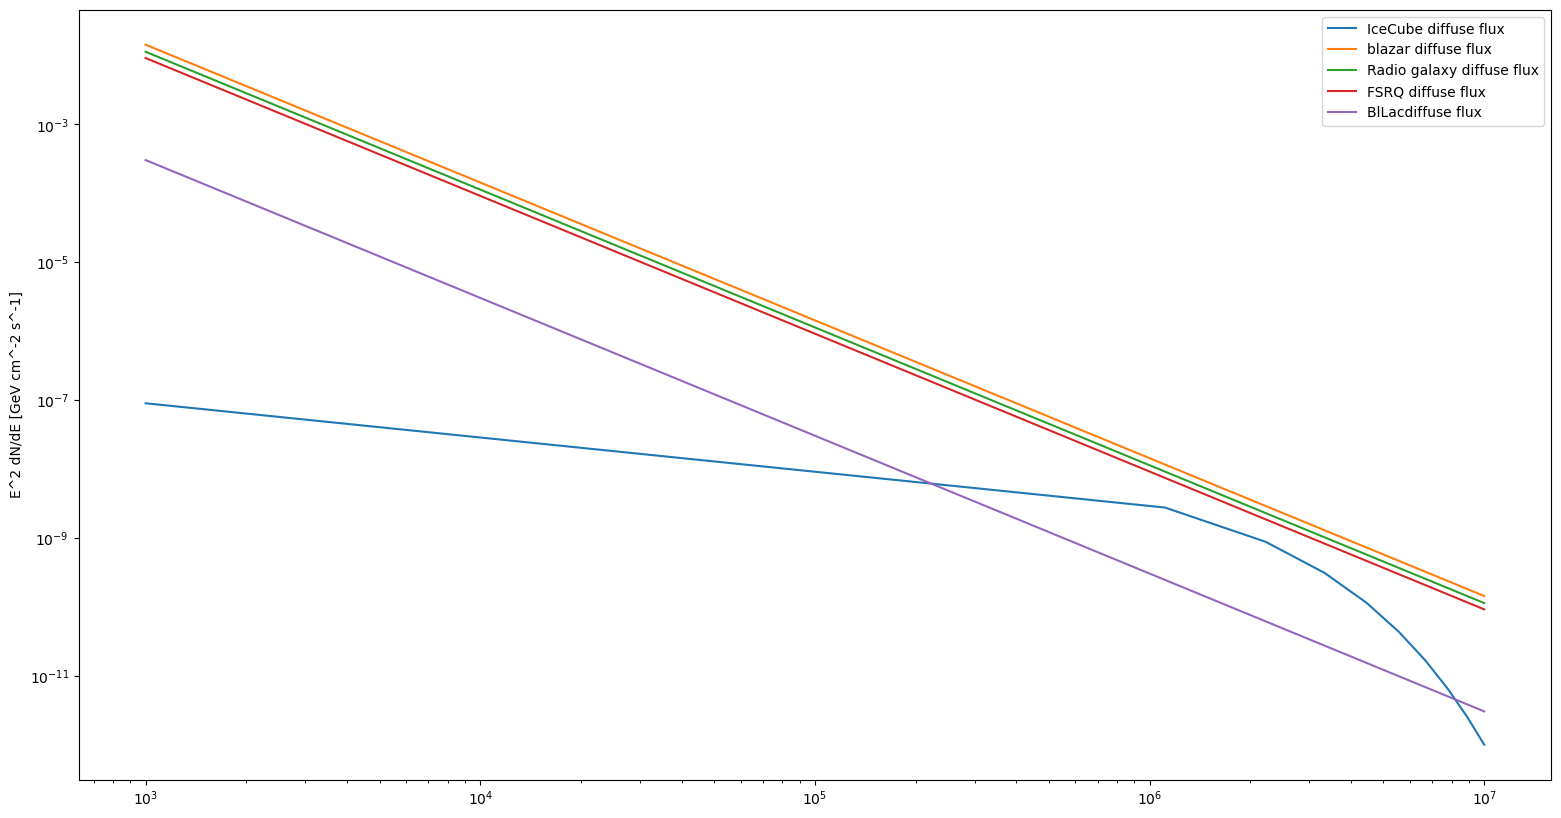

In [254]:

plt.figure(1,figsize=(19,10))
plt.plot(E_v_list,E_v_list**2*ICECUBE(E_v_list, E_cut_ice,gamma,phi_cut),label = "IceCube diffuse flux")
plt.plot(E_v_list,E_v_list**2*abs(blaz_d_phi_2),label = "blazar diffuse flux")
plt.plot(E_v_list,E_v_list**2*abs(rg_d_phi_2),label = "Radio galaxy diffuse flux")
plt.plot(E_v_list,E_v_list**2*abs(fsrq_d_phi_2),label = "FSRQ diffuse flux")
plt.plot(E_v_list,E_v_list**2*abs(bllac_d_phi_2),label = "BlLacdiffuse flux")
plt.ylabel("E^2 dN/dE [GeV cm^-2 s^-1]")
plt.yscale('log',base=10)
plt.xscale('log',base=10)
plt.legend()
plt.show()

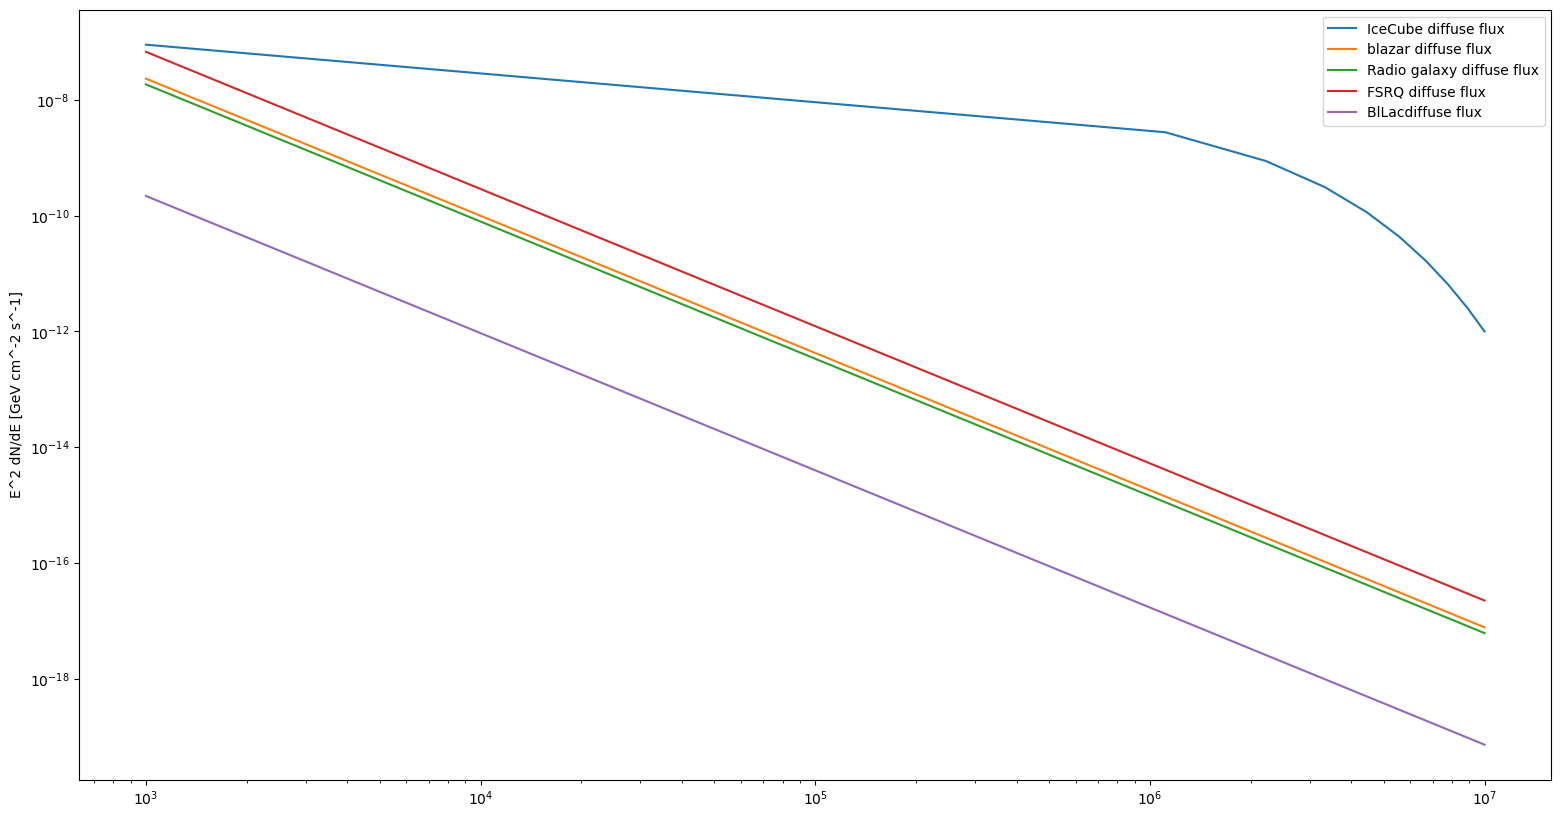

In [255]:
plt.figure(1,figsize=(19,10))
plt.plot(E_v_list,E_v_list**2*ICECUBE(E_v_list, E_cut_ice,gamma,phi_cut),label = "IceCube diffuse flux")
plt.plot(E_v_list,E_v_list**2*abs(blaz_d_phi),label = "blazar diffuse flux")
plt.plot(E_v_list,E_v_list**2*abs(rg_d_phi),label = "Radio galaxy diffuse flux")
plt.plot(E_v_list,E_v_list**2*abs(fsrq_d_phi),label = "FSRQ diffuse flux")
plt.plot(E_v_list,E_v_list**2*abs(bllac_d_phi),label = "BlLacdiffuse flux")
plt.ylabel("E^2 dN/dE [GeV cm^-2 s^-1]")
plt.yscale('log',base=10)
plt.xscale('log',base=10)
plt.legend()
plt.show()

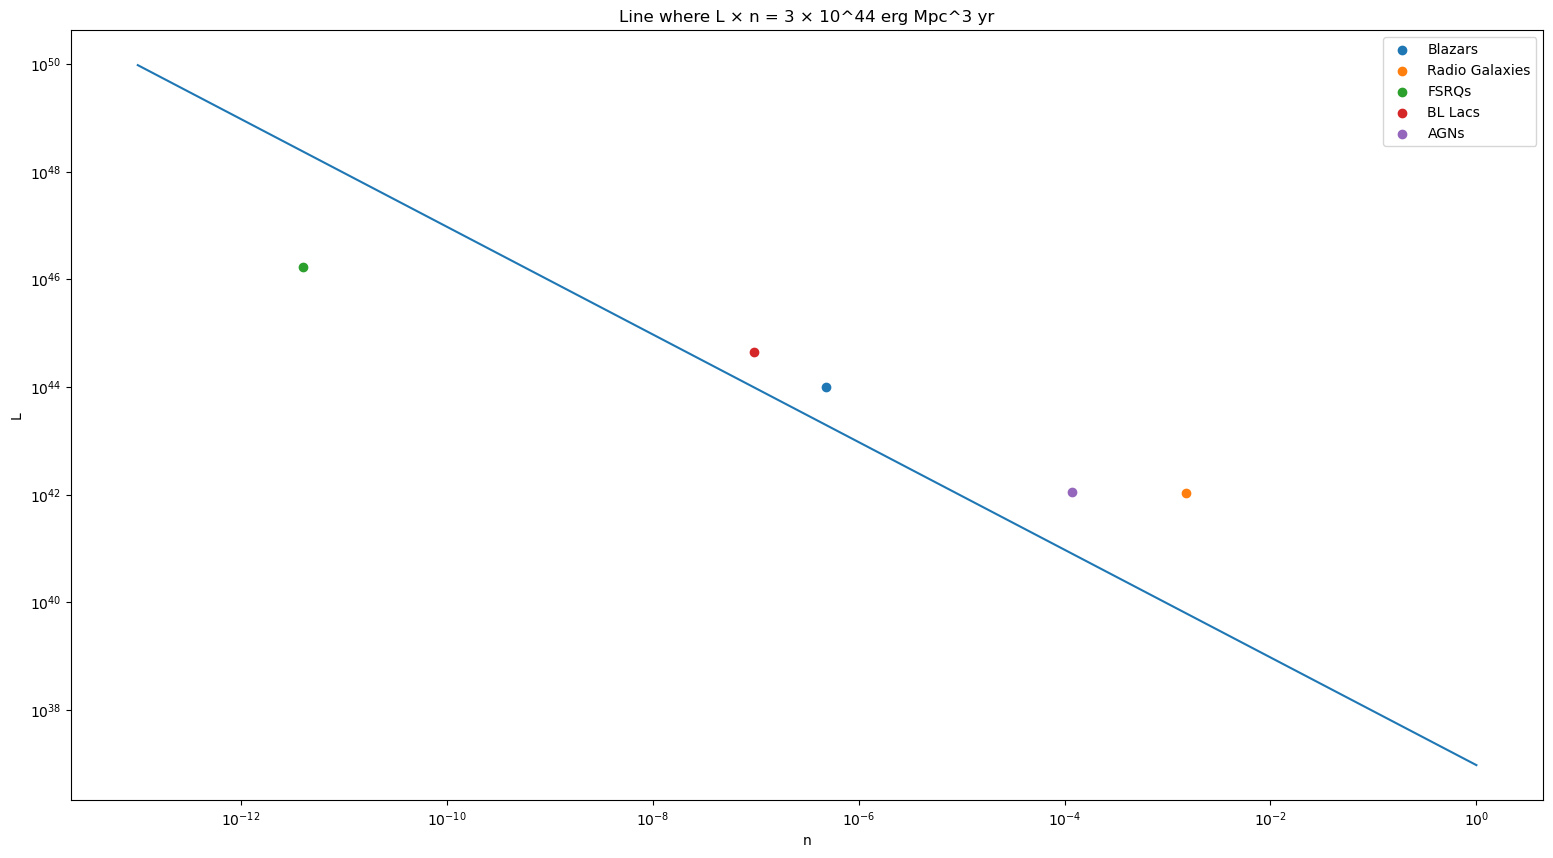

In [266]:
diffuse_flux_UHECR = 6*10**(17) #ev, do not know where this comes from. I dont get it. This turns into 3*10^44 ergs/s/Mpc^3 ??


# Define the value of n
n_values = np.logspace(-13, 0, 1000)

# Calculate the corresponding values of L
L_values = (3 * 10**44) / n_values/(60*60*24*365)

# Plot the line
plt.figure(1, figsize=(19,10))
plt.plot(n_values, L_values)

# Add labels and title
plt.xlabel('n')
plt.yscale('log',base=10)
plt.xscale('log',base=10)
plt.ylabel('L')
plt.scatter(blaz_n_tot[0], blaz_avg_tot[0], label='Blazars')
plt.scatter(rg_n_tot[0], rg_avg_tot[0], label='Radio Galaxies')
plt.scatter(fsrq_n_tot[0], fsrq_avg_tot[0], label='FSRQs')
plt.scatter(bllac_n_tot[0], bllac_avg_tot[0], label='BL Lacs')
plt.scatter(AGN_n_tot[0], AGN_avg_tot[0], label='AGNs')
plt.title('Line where L × n = 3 × 10^44 erg Mpc^3 yr')
plt.legend()

# Show the plot
plt.show()


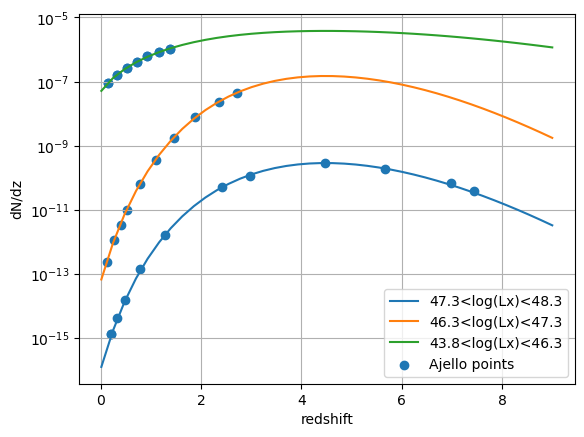

In [257]:


data = np.loadtxt('plot-data (1)_blazar_ajello.csv', delimiter=',', skiprows=1)
data = np.loadtxt('plot-data (2).csv', delimiter=',', skiprows=1)
#data2 = np.loadtxt('plot-data (1)new2.csv', delimiter=',', skiprows=1)


selected_model = 'AMPLE_Blazar'
#different models 'SLDDE_RG', 'AMPLE_Blazar', 'AMPLE_FSRQ', 'APLE_BLlac'
set_model_constants(selected_model)


integral_results_lx= prefrom_int(lx_func, Z_list,10**47.3, 10**48.3)

integral_results_lx__2= prefrom_int(lx_func, Z_list,10**46.3, 10**47.3)
integral_results_lx__3= prefrom_int(lx_func, Z_list,10**43.8, 10**46.3)
plt.figure(2)
plt.plot(Z_list,(integral_results_lx)/cosmo1.differential_comoving_volume(Z_list)/4/np.pi,label = f"{47.3}<log(Lx)<{48.3}")
plt.plot(Z_list,(integral_results_lx__2)/cosmo1.differential_comoving_volume(Z_list)/4/np.pi,label = f"{46.3}<log(Lx)<{ 47.3}")
plt.plot(Z_list,(integral_results_lx__3)/cosmo1.differential_comoving_volume(Z_list)/4/np.pi,label = f"{43.8}<log(Lx)<{ 46.3}")
plt.scatter(data[:,0],data[:,1],label = "Ajello points")
#plt.scatter(data2[:,0],data2[:,1])
plt.plot()
plt.ylabel("dN/dz")
plt.xlabel("redshift")
plt.yscale('log',base=10)
#plt.xscale('log',base=10)
#plt.ylim(10**(-1),10**(9))
#plt.xlim(10**(-2),10**(2))
plt.legend()
plt.grid()
plt.show()

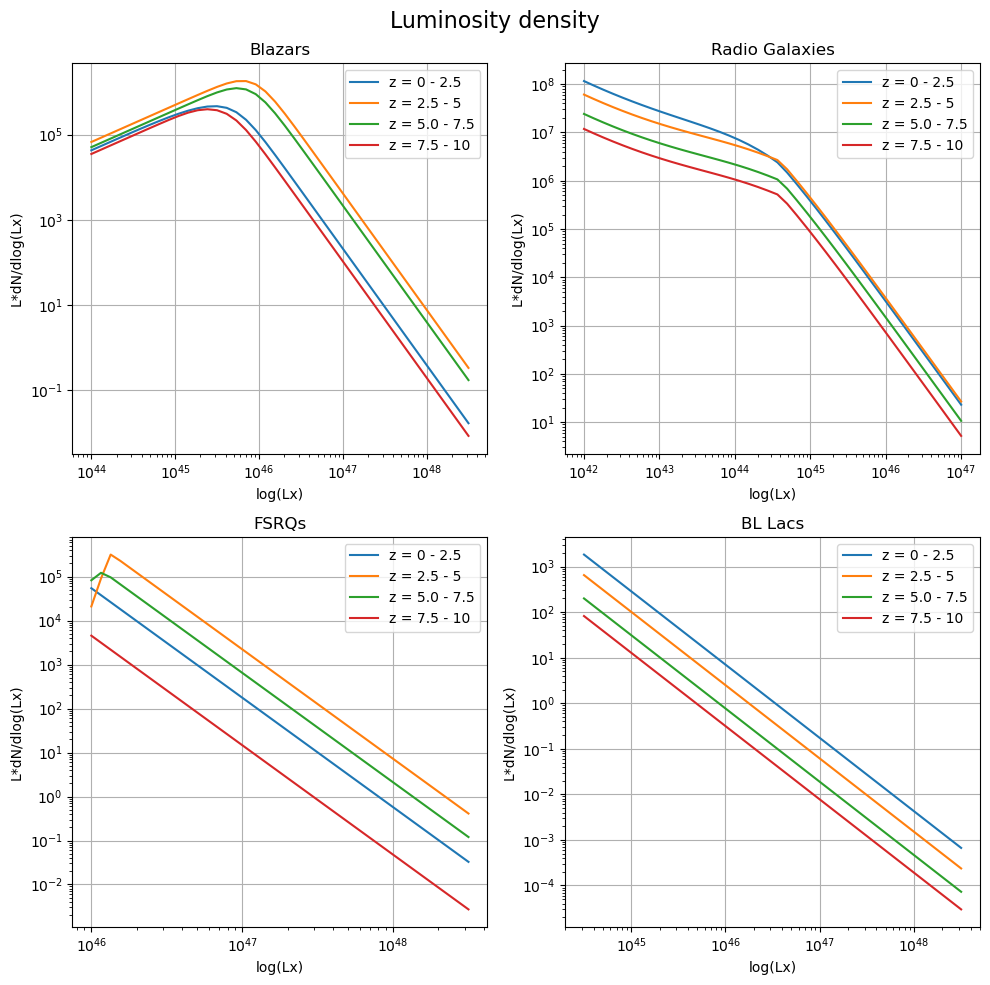

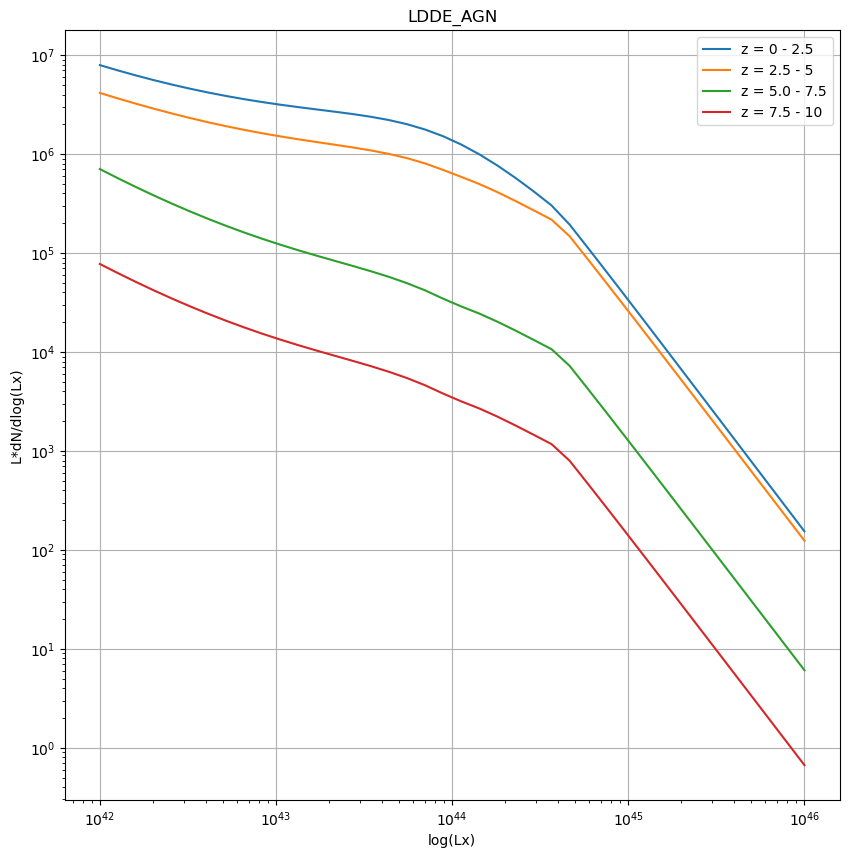

40


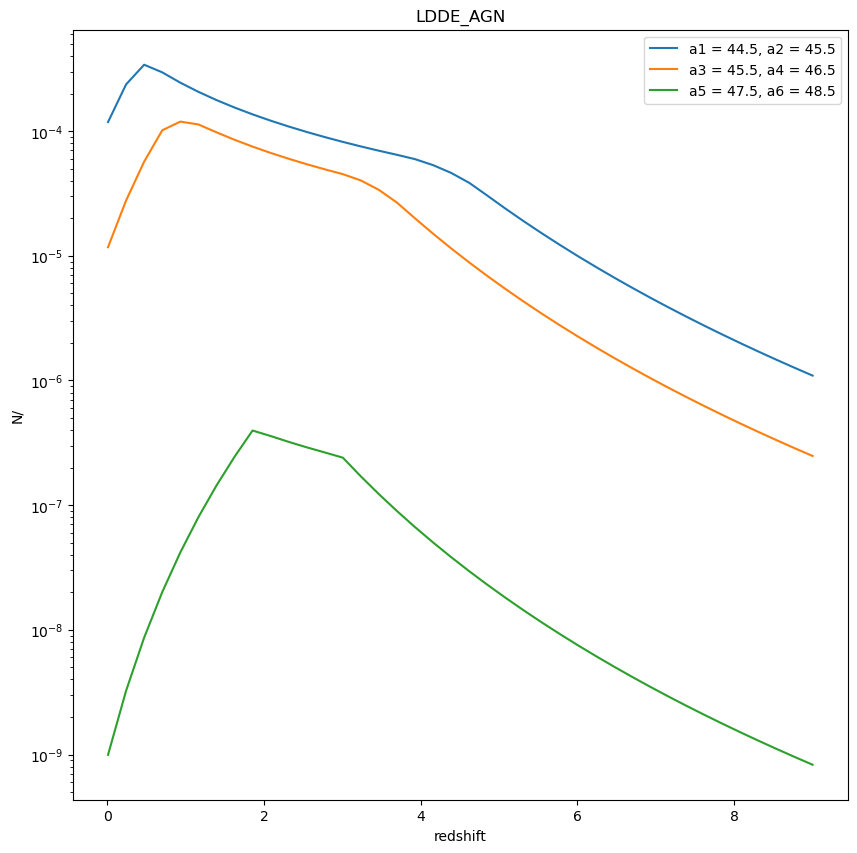

In [258]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()  
selected_model = 'AMPLE_Blazar'

set_model_constants(selected_model)
axs[0].plot(L_x, L_x* blaz_ir_z1, label='z = 0 - 2.5')
axs[0].plot(L_x, L_x* blaz_ir_z2, label='z = 2.5 - 5')
axs[0].plot(L_x, L_x* blaz_ir_z3, label='z = 5.0 - 7.5')
axs[0].plot(L_x,L_x*  blaz_ir_z4, label='z = 7.5 - 10')
axs[0].set_title('Blazars')
axs[0].set_xlabel('log(Lx)')
axs[0].set_ylabel('L*dN/dlog(Lx)')
axs[0].set_yscale('log',base=10)
axs[0].set_xscale('log',base=10)
axs[0].legend()
axs[0].grid()


selected_model = 'SLDDE_RG'

set_model_constants(selected_model)
axs[1].plot(L_x, L_x* rg_ir_z1, label='z = 0 - 2.5')
axs[1].plot(L_x, L_x* rg_ir_z2, label='z = 2.5 - 5')
axs[1].plot(L_x, L_x* rg_ir_z3, label='z = 5.0 - 7.5')
axs[1].plot(L_x, L_x* rg_ir_z4, label='z = 7.5 - 10')
axs[1].set_title('Radio Galaxies')
axs[1].set_xlabel('log(Lx)')
axs[1].set_ylabel('L*dN/dlog(Lx)')
axs[1].set_yscale('log',base=10)
axs[1].set_xscale('log',base=10)
axs[1].legend()
axs[1].grid()

selected_model = 'AMPLE_FSRQ'

set_model_constants(selected_model)

axs[2].plot(L_x,L_x*  fsrq_ir_z1, label='z = 0 - 2.5')
axs[2].plot(L_x, L_x* fsrq_ir_z2, label='z = 2.5 - 5')
axs[2].plot(L_x, L_x* fsrq_ir_z3, label='z = 5.0 - 7.5')
axs[2].plot(L_x, L_x* fsrq_ir_z4, label='z = 7.5 - 10')
axs[2].set_title('FSRQs')
axs[2].set_xlabel('log(Lx)')
axs[2].set_ylabel('L*dN/dlog(Lx)')
axs[2].set_yscale('log',base=10)
axs[2].set_xscale('log',base=10)
axs[2].legend()
axs[2].grid()

selected_model = 'APLE_BLlac'

set_model_constants(selected_model)
axs[3].plot(L_x, L_x* bllac_ir_z1, label='z = 0 - 2.5')
axs[3].plot(L_x, L_x* bllac_ir_z2, label='z = 2.5 - 5')
axs[3].plot(L_x, L_x* bllac_ir_z3, label='z = 5.0 - 7.5')
axs[3].plot(L_x, L_x* bllac_ir_z4, label='z = 7.5 - 10')
axs[3].set_title('BL Lacs')
axs[3].set_xlabel('log(Lx)')
axs[3].set_ylabel('L*dN/dlog(Lx)')
axs[3].set_yscale('log',base=10)
axs[3].set_xscale('log',base=10)
axs[3].legend()
axs[3].grid()





fig.suptitle('Luminosity density', fontsize=16)


plt.tight_layout()
#plt.savefig('Luminosity density.png')

plt.show()
plt.figure(2,figsize=(10,10))

selected_model = 'LDDE_AGN'

set_model_constants(selected_model)
plt.plot(L_x, L_x* AGN_ir_z1, label='z = 0 - 2.5')
plt.plot(L_x, L_x* AGN_ir_z2, label='z = 2.5 - 5')
plt.plot(L_x, L_x* AGN_ir_z3, label='z = 5.0 - 7.5')
plt.plot(L_x, L_x* AGN_ir_z4, label='z = 7.5 - 10')
plt.title('LDDE_AGN')
plt.xlabel('log(Lx)')
plt.ylabel('L*dN/dlog(Lx)')
plt.yscale('log',base=10)
plt.xscale('log',base=10)
plt.legend()
plt.grid()
plt.show()


plt.figure(3,figsize=(10,10))
plt.plot(Z_list, AGN_ir_lx1/cosmo1.differential_comoving_volume(Z_list), label=f'a1 = {a1}, a2 = {a2}')
plt.plot(Z_list, AGN_ir_lx2/cosmo1.differential_comoving_volume(Z_list), label=f'a3 = {a3}, a4 = {a4}')
plt.plot(Z_list, AGN_ir_lx3/cosmo1.differential_comoving_volume(Z_list), label=f'a5 = {a5}, a6 = {a6}')
#plt.plot(Z_list, AGN_ir_lx4/cosmo1.differential_comoving_volume(Z_list), label=f'a7 = {a7}, a8 = {a8}')
plt.title('LDDE_AGN')
plt.xlabel('redshift')
plt.yscale('log',base=10)
plt.ylabel('N/')
plt.legend()
print(len(Z_list))

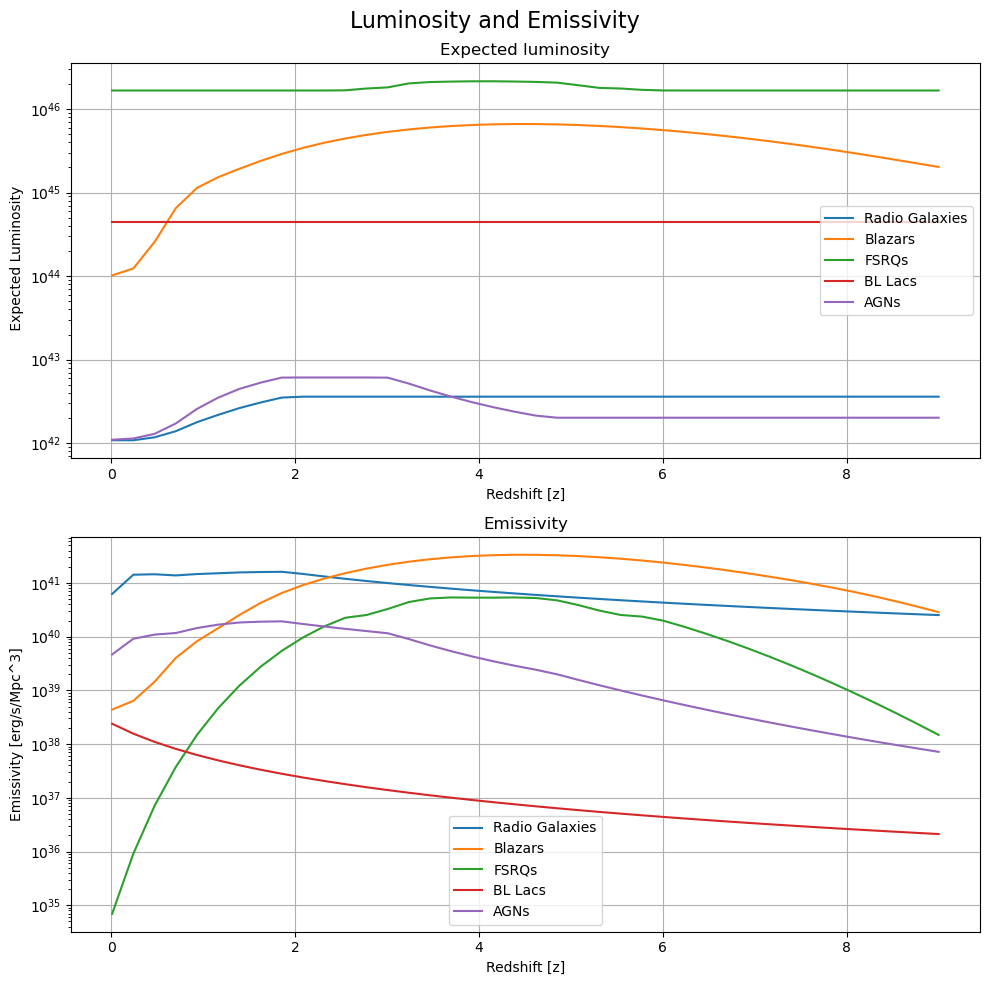

In [268]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs = axs.flatten()
axs[0].plot(Z_list, rg_avg_tot, label=f'Radio Galaxies')
axs[0].plot(Z_list, blaz_avg_tot, label=f'Blazars')
axs[0].plot(Z_list, fsrq_avg_tot, label=f'FSRQs')
axs[0].plot(Z_list, bllac_avg_tot, label=f'BL Lacs')
axs[0].plot(Z_list, AGN_avg_tot, label=f'AGNs')
axs[0].set_title('Expected luminosity')
axs[0].set_xlabel('Redshift [z]')
axs[0].set_ylabel(' Expected Luminosity')
axs[0].set_yscale('log',base=10)
axs[0].legend()
axs[0].grid()

axs[1].plot(Z_list, rg_em_tot, label=f'Radio Galaxies')
axs[1].plot(Z_list, blaz_em_tot, label=f'Blazars')
axs[1].plot(Z_list, fsrq_em_tot, label=f'FSRQs')
axs[1].plot(Z_list, bllac_em_tot, label=f'BL Lacs')
axs[1].plot(Z_list, AGN_em_tot, label=f'AGNs')
#axs[1].plot(Z_list,fsrq_em_tot+bllac_em_tot, label=f'Bllacs + FSRQs')
axs[1].set_title('Emissivity')
axs[1].set_xlabel('Redshift [z]')
axs[1].set_ylabel('Emissivity [erg/s/Mpc^3]')
axs[1].set_yscale('log',base=10)
axs[1].legend()
axs[1].grid()

fig.suptitle('Luminosity and Emissivity', fontsize=16)
plt.tight_layout()
#plt.savefig('Luminosity and Emissivity.png')

plt.show()










[1.000e+03 1.112e+06 2.223e+06 3.334e+06 4.445e+06 5.556e+06 6.667e+06
 7.778e+06 8.889e+06 1.000e+07]
<function integrandBlazar at 0x0000020649CB8160>
[1.00000000e+44 1.30432139e+44 1.70125428e+44 2.21898234e+44
 2.89426612e+44 3.77505321e+44 4.92388263e+44 6.42232542e+44
 8.37677640e+44 1.09260086e+45 1.42510267e+45 1.85879189e+45
 2.42446202e+45 3.16227766e+45 4.12462638e+45 5.37983840e+45
 7.01703829e+45 9.15247311e+45 1.19377664e+46 1.55706840e+46
 2.03091762e+46 2.64896929e+46 3.45510729e+46 4.50657034e+46
 5.87801607e+46 7.66682207e+46 1.00000000e+47 1.30432139e+47
 1.70125428e+47 2.21898234e+47 2.89426612e+47 3.77505321e+47
 4.92388263e+47 6.42232542e+47 8.37677640e+47 1.09260086e+48
 1.42510267e+48 1.85879189e+48 2.42446202e+48 3.16227766e+48]


c:\Users\henri\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Fit parameters for D_list: a=624212.42, b=1.00
10
Start phi2 calc for AMPLE_Blazar
End


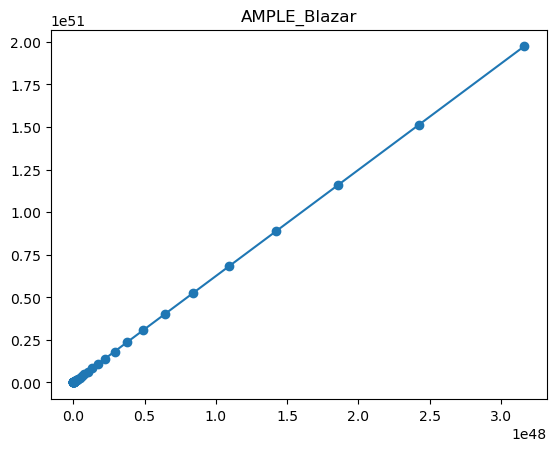

done 1
done 2
done 3
AMPLE_Blazar
done 1
done 2
done 3
The model in question is:  AMPLE_Blazar
Fit parameters for array 1: a=11451616352688064310919219318678889411796533248.00, b=-1.23, c=5.59, e=3.15
Fit parameters for array 2: a=98211956629262785119701486594504313707002068992.00, b=-0.00, c=98.55, e=0.00
Fit parameters for array 3: a=981279776782762341251051967695495801811243106304.00, b=-0.00, c=1.70, e=0.00
Fit parameters for avg_tot: a=12336889810168348639218134370323076392188641280.00, b=3.23, c=5.48, e=-1.33
Fit parameters for em_tot: a=650515505629626602580294554285991689977856.00, b=4.48, c=5.07, e=-2.14
Fit parameters for n_tot: a=0.00, b=-1.35, c=5.46, e=3.25


C:\Users\henri\AppData\Local\Temp\ipykernel_5492\3311138847.py:24: RuntimeWarning: invalid value encountered in power
  return a*((z/c)**b+(z/c)**e)**(-1)
C:\Users\henri\AppData\Local\Temp\ipykernel_5492\3311138847.py:24: RuntimeWarning: overflow encountered in power
  return a*((z/c)**b+(z/c)**e)**(-1)


Fit parameters for D_list: a=11015671.60, b=1.00


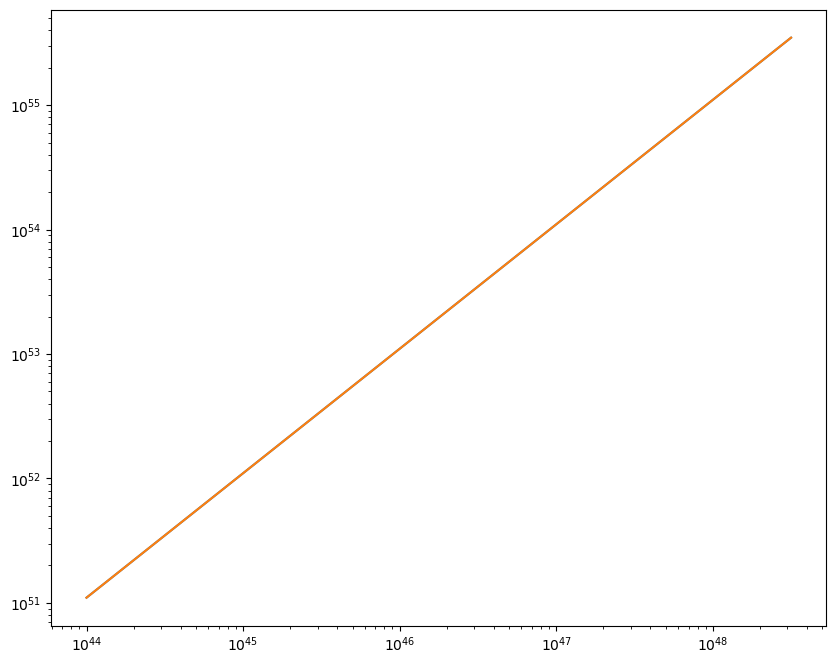

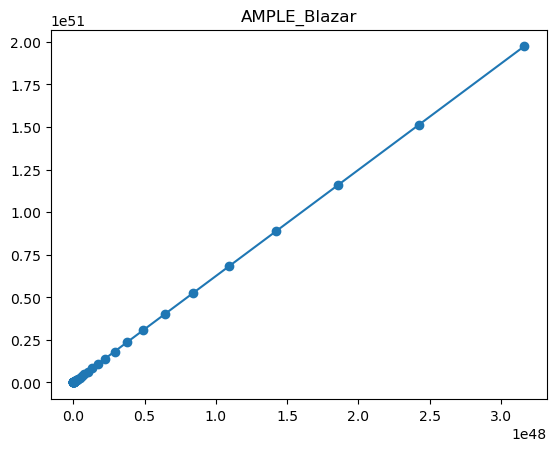

[1.000e+03 1.112e+06 2.223e+06 3.334e+06 4.445e+06 5.556e+06 6.667e+06
 7.778e+06 8.889e+06 1.000e+07]
<function integrandRG at 0x00000206484A81F0>
[1.00000000e+42 1.34339933e+42 1.80472177e+42 2.42446202e+42
 3.25702066e+42 4.37547938e+42 5.87801607e+42 7.89652287e+42
 1.06081836e+43 1.42510267e+43 1.91448198e+43 2.57191381e+43
 3.45510729e+43 4.64158883e+43 6.23550734e+43 8.37677640e+43
 1.12533558e+44 1.51177507e+44 2.03091762e+44 2.72833338e+44
 3.66524124e+44 4.92388263e+44 6.61474064e+44 8.88623816e+44
 1.19377664e+45 1.60371874e+45 2.15443469e+45 2.89426612e+45
 3.88815518e+45 5.22334507e+45 7.01703829e+45 9.42668455e+45
 1.26638017e+46 1.70125428e+46 2.28546386e+46 3.07029063e+46
 4.12462638e+46 5.54102033e+46 7.44380301e+46 1.00000000e+47]
Fit parameters for D_list: a=624212.42, b=1.00
10
Start phi2 calc for SLDDE_RG
End


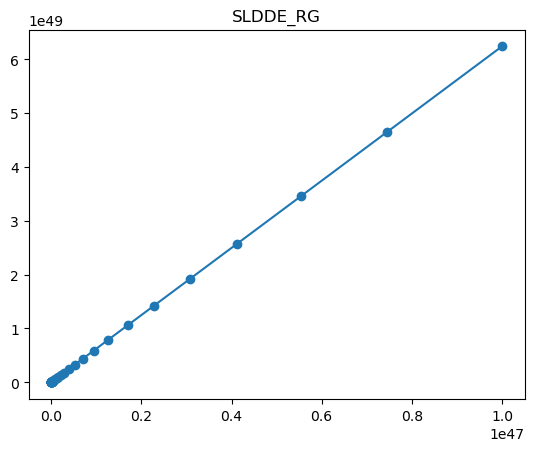

done 1
done 2
done 3
SLDDE_RG
done 1
done 2
done 3
The model in question is:  SLDDE_RG
Fit parameters for array 1: a=7880528129306117106974826088379001006456832.00, b=-0.13, c=29.72, e=0.92
Fit parameters for array 2: a=208460953111043717073390185959093149995368448.00, b=2.10, c=15.47, e=-0.23
Fit parameters for array 3: a=3821663355930172863655890097520379395410231296.00, b=-0.00, c=2.18, e=0.00
Fit parameters for avg_tot: a=6051177094736435124597411771038945178025984.00, b=0.28, c=1.70, e=-1.17
Fit parameters for em_tot: a=218780239458422771718080878485216820199424.00, b=1.97, c=2.86, e=-0.22
Fit parameters for n_tot: a=0.01, b=1.42, c=0.92, e=-0.37
Fit parameters for D_list: a=11015671.60, b=1.00


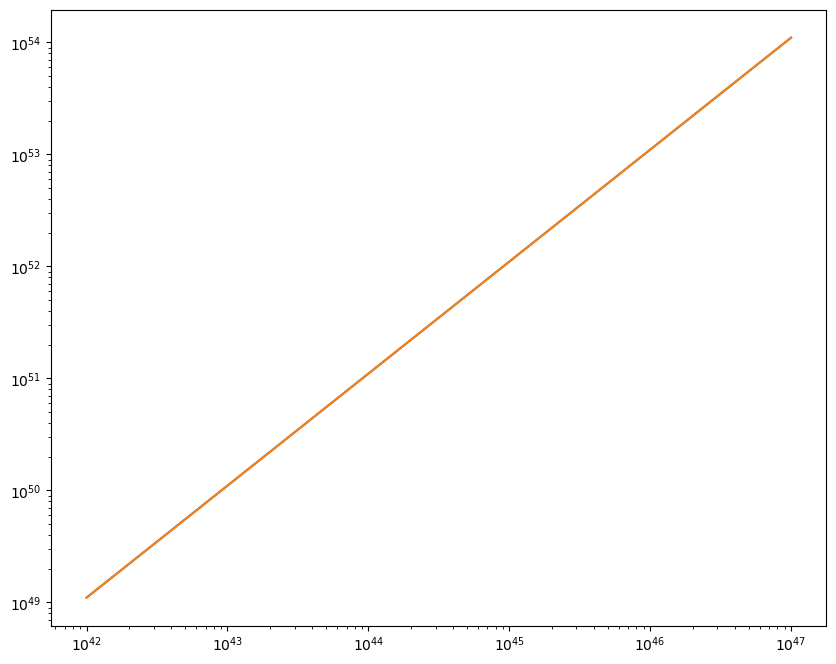

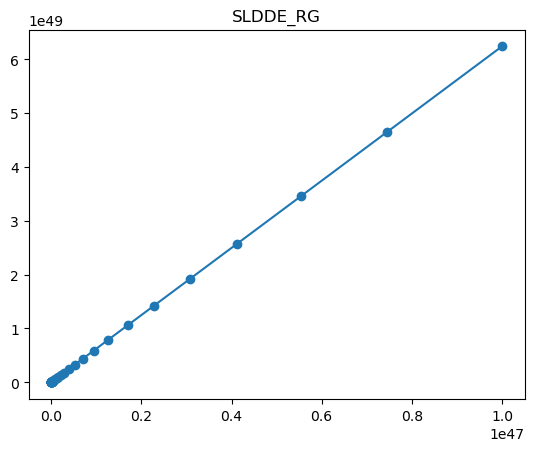

In [199]:

selected_model = 'AMPLE_Blazar'
#different models 'SLDDE_RG', 'AMPLE_Blazar', 'AMPLE_FSRQ', 'APLE_BLlac'
set_model_constants(selected_model)
print(E_v_list)
print(integrand)
print(L_x)

D_list_2, popt_tot_D_2 = D_fit_2()
blaz_d_phi_2 = calc_phi_2()


plt.figure()
plt.scatter(L_x, L_x*624.15)
test_d = []
for i in range(len(L_x)):
    test_d.append(integrate_SED_2(lin_func(L_x[i], *popt_tot_D_2),L_x[i]*624.15,SED_neut_2))

plt.plot(L_x, test_d)
plt.title(selected_model)
plt.show()

blaz_ir_z1, blaz_ir_z2, blaz_ir_z3, blaz_ir_z4 = lum_den_calc()
blaz_ir_lx1, blaz_ir_lx2, blaz_ir_lx3, blaz_ir_lx4 = red_evo_calc()
blaz_em_j1, blaz_em_j2, blaz_em_j3, blaz_em_tot, blaz_avg_lx1, blaz_avg_lx2, blaz_avg_lx3, blaz_avg_tot = em_avg_calc(blaz_ir_lx1, blaz_ir_lx2, blaz_ir_lx3, blaz_ir_lx4)

blaz_n_tot =(blaz_ir_lx1)/cosmo1.differential_comoving_volume(Z_list).value
popt1, popt2, popt3, popt_tot, popt_tot_em, popt_tot_n = return_fit_varaibles(blaz_avg_lx1, blaz_avg_lx2, blaz_avg_lx3, blaz_avg_tot, blaz_em_tot, blaz_n_tot,4)
D_list, popt_tot_D = D_list_calc(4)
blaz_d_phi = calc_phi()


plt.figure()
plt.scatter(L_x, L_x*624.15)
test_d = []
for i in range(len(L_x)):
    test_d.append(integrate_SED(D_func(L_x[i], *popt_tot_D),SED_neut))

plt.plot(L_x, test_d)
plt.title(selected_model)
plt.show()


selected_model = 'SLDDE_RG'
#different models 'SLDDE_RG', 'AMPLE_Blazar', 'AMPLE_FSRQ', 'APLE_BLlac'
set_model_constants(selected_model)
print(E_v_list)
print(integrand)
print(L_x)
D_list_2, popt_tot_D_2 = D_fit_2()
rg_d_phi_2 = calc_phi_2()

plt.figure()
plt.scatter(L_x, L_x*624.15)
test_d = []
for i in range(len(L_x)):
    test_d.append(integrate_SED_2(lin_func(L_x[i], *popt_tot_D_2),L_x[i]*624.15,SED_neut_2))

plt.plot(L_x, test_d)
plt.title(selected_model)
plt.show()


rg_ir_z1, rg_ir_z2, rg_ir_z3, rg_ir_z4 = lum_den_calc()
rg_ir_lx1, rg_ir_lx2, rg_ir_lx3, rg_ir_lx4 = red_evo_calc()
rg_em_j1, rg_em_j2, rg_em_j3, rg_em_tot, rg_avg_lx1, rg_avg_lx2, rg_avg_lx3, rg_avg_tot = em_avg_calc(rg_ir_lx1, rg_ir_lx2, rg_ir_lx3, rg_ir_lx4)

rg_n_tot =(rg_ir_lx1)/cosmo1.differential_comoving_volume(Z_list).value
popt1, popt2, popt3, popt_tot, popt_tot_em, popt_tot_n = return_fit_varaibles(rg_avg_lx1, rg_avg_lx2, rg_avg_lx3, rg_avg_tot, rg_em_tot, rg_n_tot,1.5)
D_list, popt_tot_D = D_list_calc(0.5)
rg_d_phi = calc_phi()


plt.figure()
plt.scatter(L_x, L_x*624.15)
test_d = []
for i in range(len(L_x)):
    test_d.append(integrate_SED(D_func(L_x[i], *popt_tot_D),SED_neut))

plt.plot(L_x, test_d)
plt.title(selected_model)
plt.show()





In [ ]:
selected_model = 'AMPLE_FSRQ'
#different models 'SLDDE_RG', 'AMPLE_Blazar', 'AMPLE_FSRQ', 'APLE_BLlac'
set_model_constants(selected_model)
print(E_v_list)

D_list_2, popt_tot_D_2 = D_fit_2()
fsrq_d_phi_2 = calc_phi_2()

selected_model = 'APLE_BLlac'
#different models 'SLDDE_RG', 'AMPLE_Blazar', 'AMPLE_FSRQ', 'APLE_BLlac'
set_model_constants(selected_model)
print(E_v_list)

D_list_2, popt_tot_D_2 = D_fit_2()
bllac_d_phi_2 = calc_phi_2()

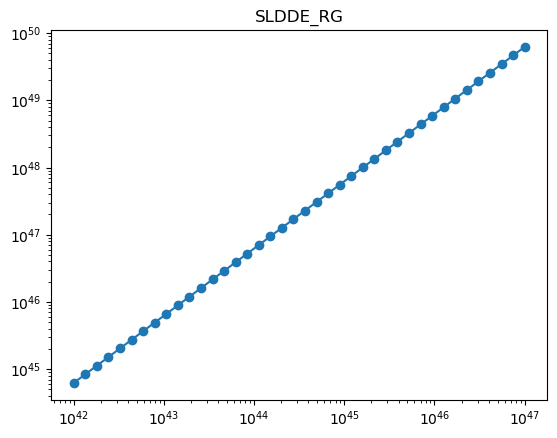

In [197]:
plt.figure()
plt.scatter(L_x, L_x*624.15)
test_d = []
for i in range(len(L_x)):
    test_d.append(integrate_SED(D_func(L_x[i]*624.15, *popt_tot_D),SED_neut))

plt.plot(L_x, test_d)
plt.xscale('log',base=10)
plt.yscale('log',base=10)
plt.title(selected_model)
plt.show()

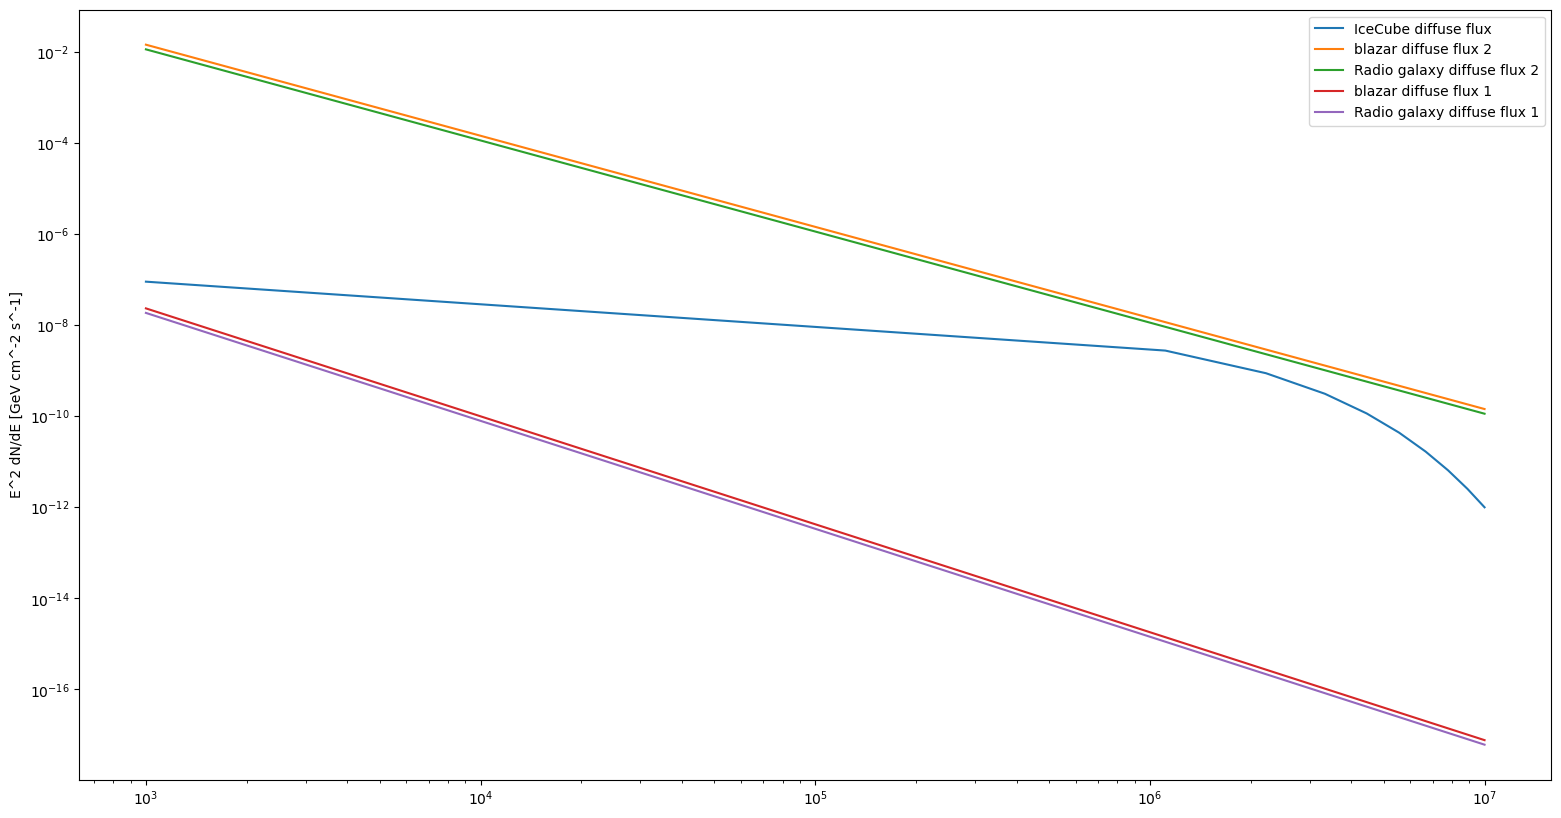

[47842.34182493 47842.34182493 47842.34182493 47842.34182493
 47842.34182493 47842.34182493 47842.34182493 47842.34182493
 47842.34182493 47842.34182493]
[47500.88955535 47500.88955535 47500.88955535 47500.88955535
 47500.88955535 47500.88955535 47500.88955535 47500.88955535
 47500.88955535 47500.88955535]
217.94494717703367
6.05612416635827
24.19155134996809


In [207]:
plt.figure(1,figsize=(19,10))
plt.plot(E_v_list,E_v_list**2*ICECUBE(E_v_list, E_cut_ice,gamma,phi_cut),label = "IceCube diffuse flux")
plt.plot(E_v_list,E_v_list**2*abs(blaz_d_phi_2),label = "blazar diffuse flux 2")
plt.plot(E_v_list,E_v_list**2*abs(rg_d_phi_2),label = "Radio galaxy diffuse flux 2")
plt.plot(E_v_list,E_v_list**2*abs(blaz_d_phi),label = "blazar diffuse flux 1")
plt.plot(E_v_list,E_v_list**2*abs(rg_d_phi),label = "Radio galaxy diffuse flux 1")

plt.ylabel("E^2 dN/dE [GeV cm^-2 s^-1]")
plt.yscale('log',base=10)
plt.xscale('log',base=10)
plt.legend()
plt.show()

print(blaz_d_phi_2/(E_v_list**0.37*blaz_d_phi))
print(rg_d_phi_2/(E_v_list**0.37*rg_d_phi))
#29860797.65003239
#29647680.21597082
print(np.sqrt(47500))
print(47500/(624.15*np.pi*4))
print(76/np.pi)

In [151]:
print(blaz_d_phi_2)
print(rg_d_phi_2)

[1.36664563e-08 6.67080119e-22 3.23243995e-23 5.49915885e-24
 1.56479087e-24 5.90262159e-25 2.66121418e-25 1.35694744e-25
 7.57126972e-26 4.52538901e-26]
[1.34501809e-08 6.56523390e-22 3.18128569e-23 5.41213314e-24
 1.54002762e-24 5.80921096e-25 2.61909973e-25 1.33547337e-25
 7.45145227e-26 4.45377347e-26]
